# Looking at the Transcript Count Data from Browder et. al 2022

`GSE190986`: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE190986
https://www.nature.com/articles/s43587-022-00183-2

`In vivo partial reprogramming alters age-associated molecular changes during physiological aging in mice`

This article doesn't seem to be on SciHub, so I'll try to infer things where I can.

Specifically, this notebook is going to look at the transcriptional data and to look at this part from the abstract:
```
The rejuvenating effects were associated with a reversion of the epigenetic clock and metabolic and transcriptomic changes, including reduced expression of genes involved in the inflammation, senescence and stress response pathways
```

The experimental variables are:

    * Organ
        - Kidney, liver, lung, skeletal muscle, skin, spleen
    * Mouse strain
        - B6 Mice: I think this is the "aging mouse model" they mentioned
        - i4F-A Mice: This mouse has an expression cassette for the 4 Yamanaka factors that's Tet (Dox) inducible 
    * -Dox and +Dox
    * Old and young

# Setup

- Standard imports
- The curated gene list from the supplemental
- Lists of Ensembl IDs for additional gene sets of interest
- Load in the Ensembl mouse GTF so we can calculate TPMs from what seems to be a count of reads

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gffutils

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

gsea_gene_list = pd.read_excel('43587_2022_183_MOESM2_ESM.xls', sheet_name='Table 5 Gene list_GSEA').drop('Unnamed: 3', axis=1)
gsea_gene_list.head()

fasta = 'GCF_000001635.27_GRCm39_genomic.fna'
db = gffutils.FeatureDB(dbfn='Mus_musculus.GRCm39.107.db')


feature_lengths = {
    feature.id: np.abs(feature.start - feature.end) 
    for feature in db.all_features()
}

act1 = ['ENSMUSG00000019842']  # ACT1, should also be a housekeeping gene in mice?
gapdh = ['ENSMUSG00000057666']  # Gapdh -- they use it in ext. fig 1
yamanaka_factors = [
    'ENSMUSG00000024406',  # Pou5f1
    'ENSMUSG00000003032',  # Klf1
    'ENSMUSG00000074637',  # Sox2
    'ENSMUSG00000022346'   # Myc
]

# Formatting the quants and metadata

- Parsing weird GEO format
- Calculating TPMs from what seems to be NumReads

We downloaded and decompressed what seems to be the read counts from GEO: https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE190986&format=file

These look like standardized files but I don't want to use whatever R package probably exists to easily parse this. Excuse this hackiness, I know this just seems sloppy, but for speed's sake:

In [33]:
# !wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE190nnn/GSE190986/matrix/GSE190986_series_matrix.txt.gz
# !gunzip GSE190986_series_matrix.txt.gz

GSE190986_series_matrix = pd.read_csv('GSE190986_series_matrix.txt', delimiter='\t', skiprows=26, index_col=0)
sample_characteristics_index = GSE190986_series_matrix.index.str.contains('Sample_characteristics')
sample_geo_accession_index = GSE190986_series_matrix.index.str.contains('Sample_geo_accession')
sample_characteristics_df = GSE190986_series_matrix[sample_characteristics_index]


metadata = {}
for sample_title in sample_characteristics_df:
    traits = sample_characteristics_df[sample_title].str.split(':', expand=True).iloc[:, [0, 1]]
    traits_dict = dict(zip(traits[0].str.strip(), traits[1].str.strip()))
    metadata[sample_title] = traits_dict
    
metadata = pd.DataFrame.from_dict(metadata, orient='index')
metadata['age'] = metadata['age'].str.split(' ', expand=True)[0].map(int)
count_filenames = list(Path('GSE190986_RAW/').glob('*.tsv'))

geo_accession_to_title = {'_'.join(tsv.stem.split('_')[1:-1]): tsv.stem.split('_')[0] for tsv in count_filenames}
metadata['geo'] = metadata.index.map(geo_accession_to_title)
metadata.index.names = ['title']

counts = pd.concat([pd.read_csv(tsv, delimiter='\t') for tsv in Path('GSE190986_RAW').glob('*.tsv')], axis=1)
counts.index.names = ['ID']
counts = counts.reset_index().melt(id_vars='ID', var_name='title', value_name='numreads')

# NumReads --> TPMs
counts['gene_len'] = counts['ID'].map(feature_lengths) / 1E3  # length in Kbp
scaling_factors = {}

for title, sub_df in counts.groupby('title'):
    scaling_factors[title] = sub_df['numreads'].sum() / 1E6
    
counts['scaling_factor'] = counts['title'].map(scaling_factors)
counts['tpm'] = counts['numreads'] / counts['gene_len'] / counts['scaling_factor']

metadata.head()
counts.head()

,strain,Sex,age,tissue,treatment,geo
title,,,,,,
Kidney_4F_6535,4F het; R26,Male,22,Kidney,Doxycycline-induced 4F,GSM5737007
Kidney_4F_6536,4F het; R26,Male,22,Kidney,Doxycycline-induced 4F,GSM5737008
Kidney_4F_6537,4F het; R26,Female,22,Kidney,Doxycycline-induced 4F,GSM5737009
Kidney_4F_6538,4F het; R26,Female,22,Kidney,Doxycycline-induced 4F,GSM5737010
Kidney_4F_6539,4F het; R26,Female,22,Kidney,Doxycycline-induced 4F,GSM5737011


,ID,title,numreads,gene_len,scaling_factor,tpm
0,ENSMUSG00000000001,4F_Skin_dox-treated_0997,2704,38.866,38.810518,1.792617
1,ENSMUSG00000000003,4F_Skin_dox-treated_0997,0,15.722,38.810518,0.000000
2,ENSMUSG00000000028,4F_Skin_dox-treated_0997,210,31.540,38.810518,0.171557
3,ENSMUSG00000000031,4F_Skin_dox-treated_0997,40944,2.624,38.810518,402.047160
4,ENSMUSG00000000037,4F_Skin_dox-treated_0997,42,175.688,38.810518,0.006160


# Sanity check: Yamanaka factors in the 4F mouse

They should be highly expressed in Dox+ strains.

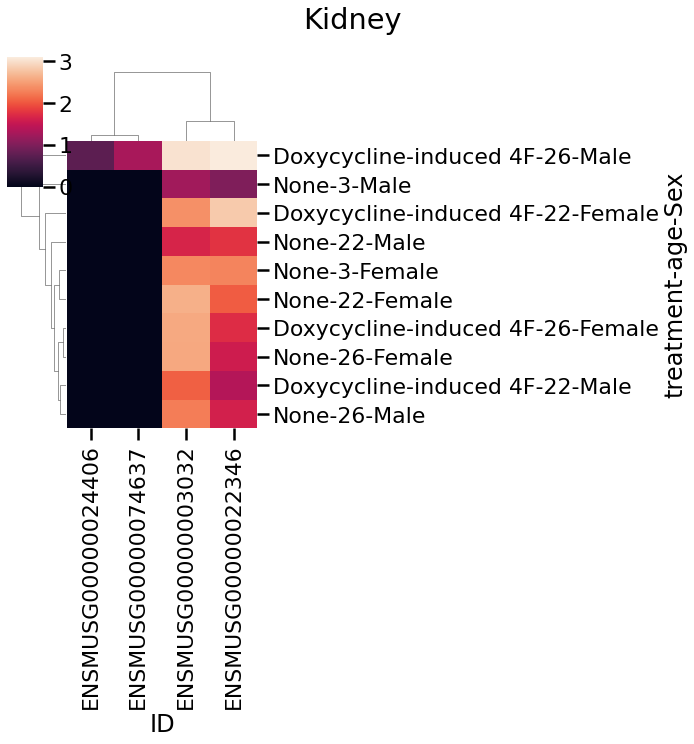

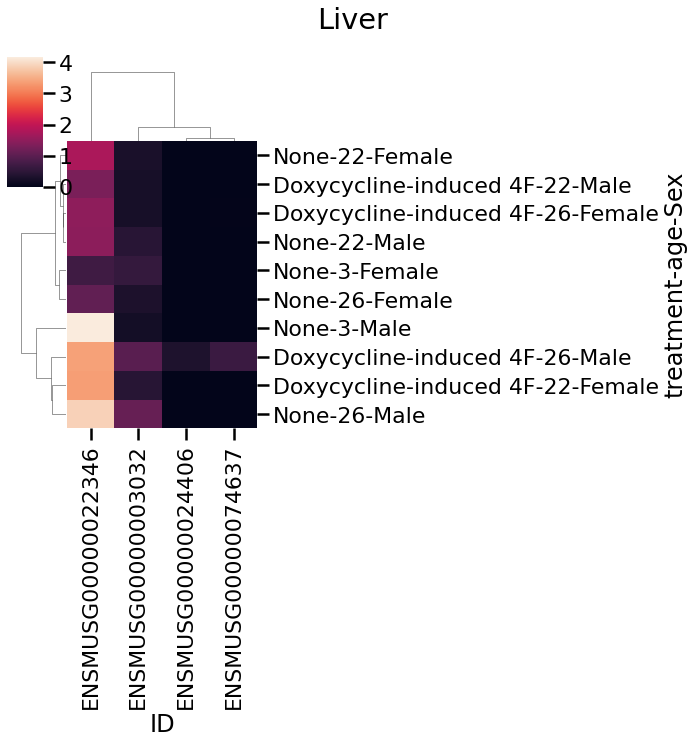

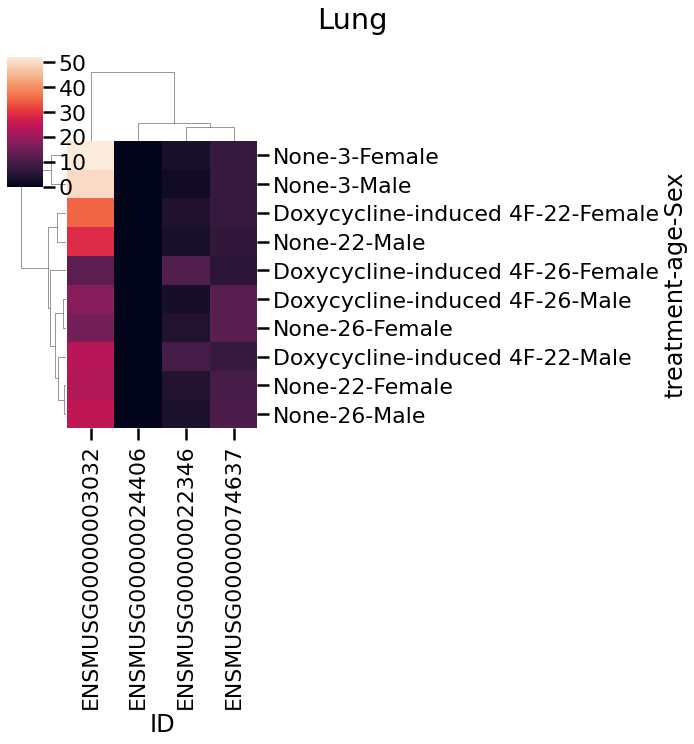

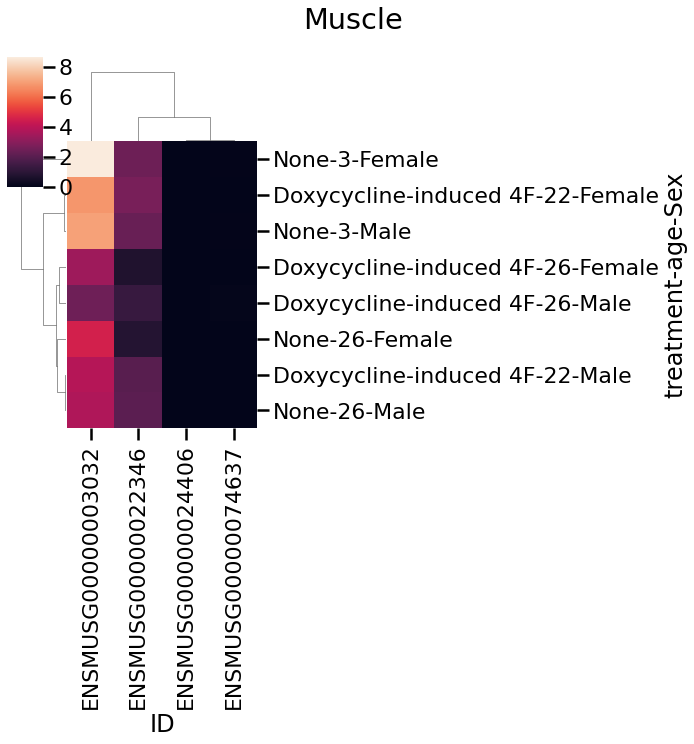

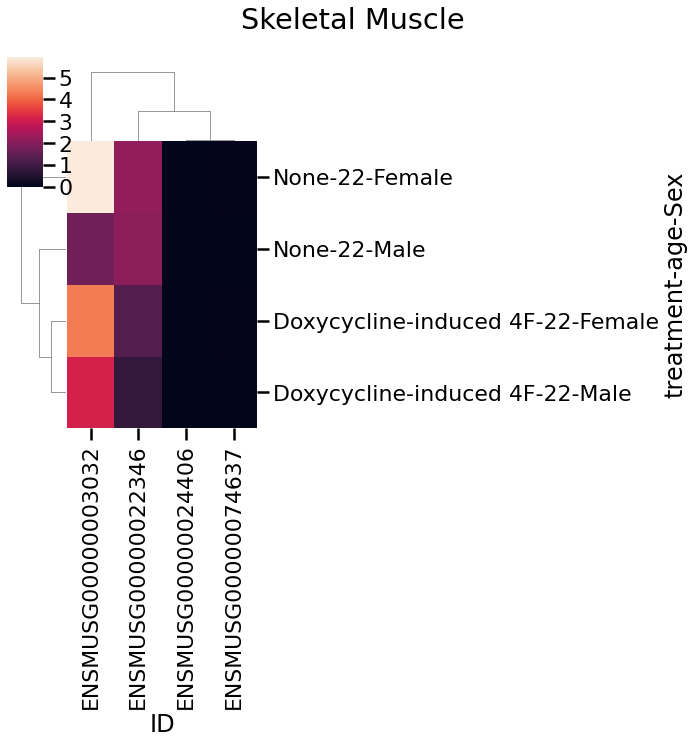

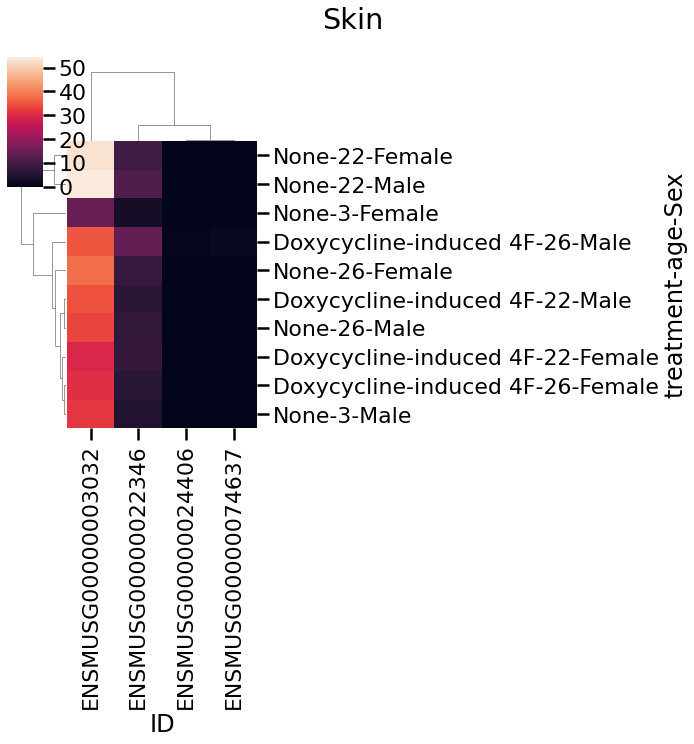

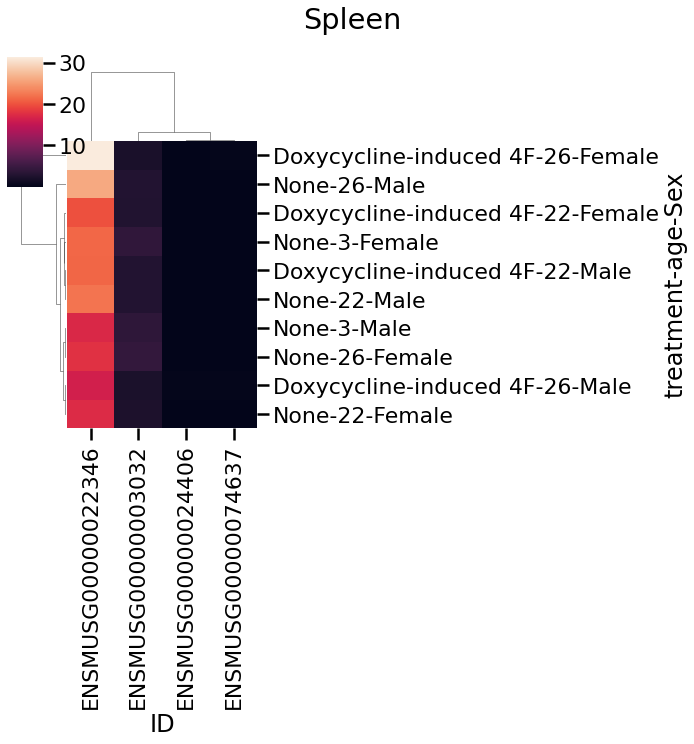

In [61]:
yamanaka_counts = counts[counts['ID'].isin(yamanaka_factors)]
yamanaka_full = metadata.merge(yamanaka_counts, left_index=True, right_on='title').query('strain == "4F het; R26"')

with sns.plotting_context('poster'):
    for tissue, tissue_df in yamanaka_full.groupby('tissue'):
        data = tissue_df.copy()
        data = (
            data.pivot_table(index=['treatment', 'age', 'Sex'], columns='ID', values='tpm')
                .replace(np.nan, 0)
        )
        g = sns.clustermap(
            data=data, 
            robust=True
        )
        _ = g.fig.suptitle(tissue, y=1.05)
        ax_heatmap = g.ax_heatmap
        _ = ax_heatmap.set_xticklabels(ax_heatmap.get_xticklabels(), rotation=90)
                

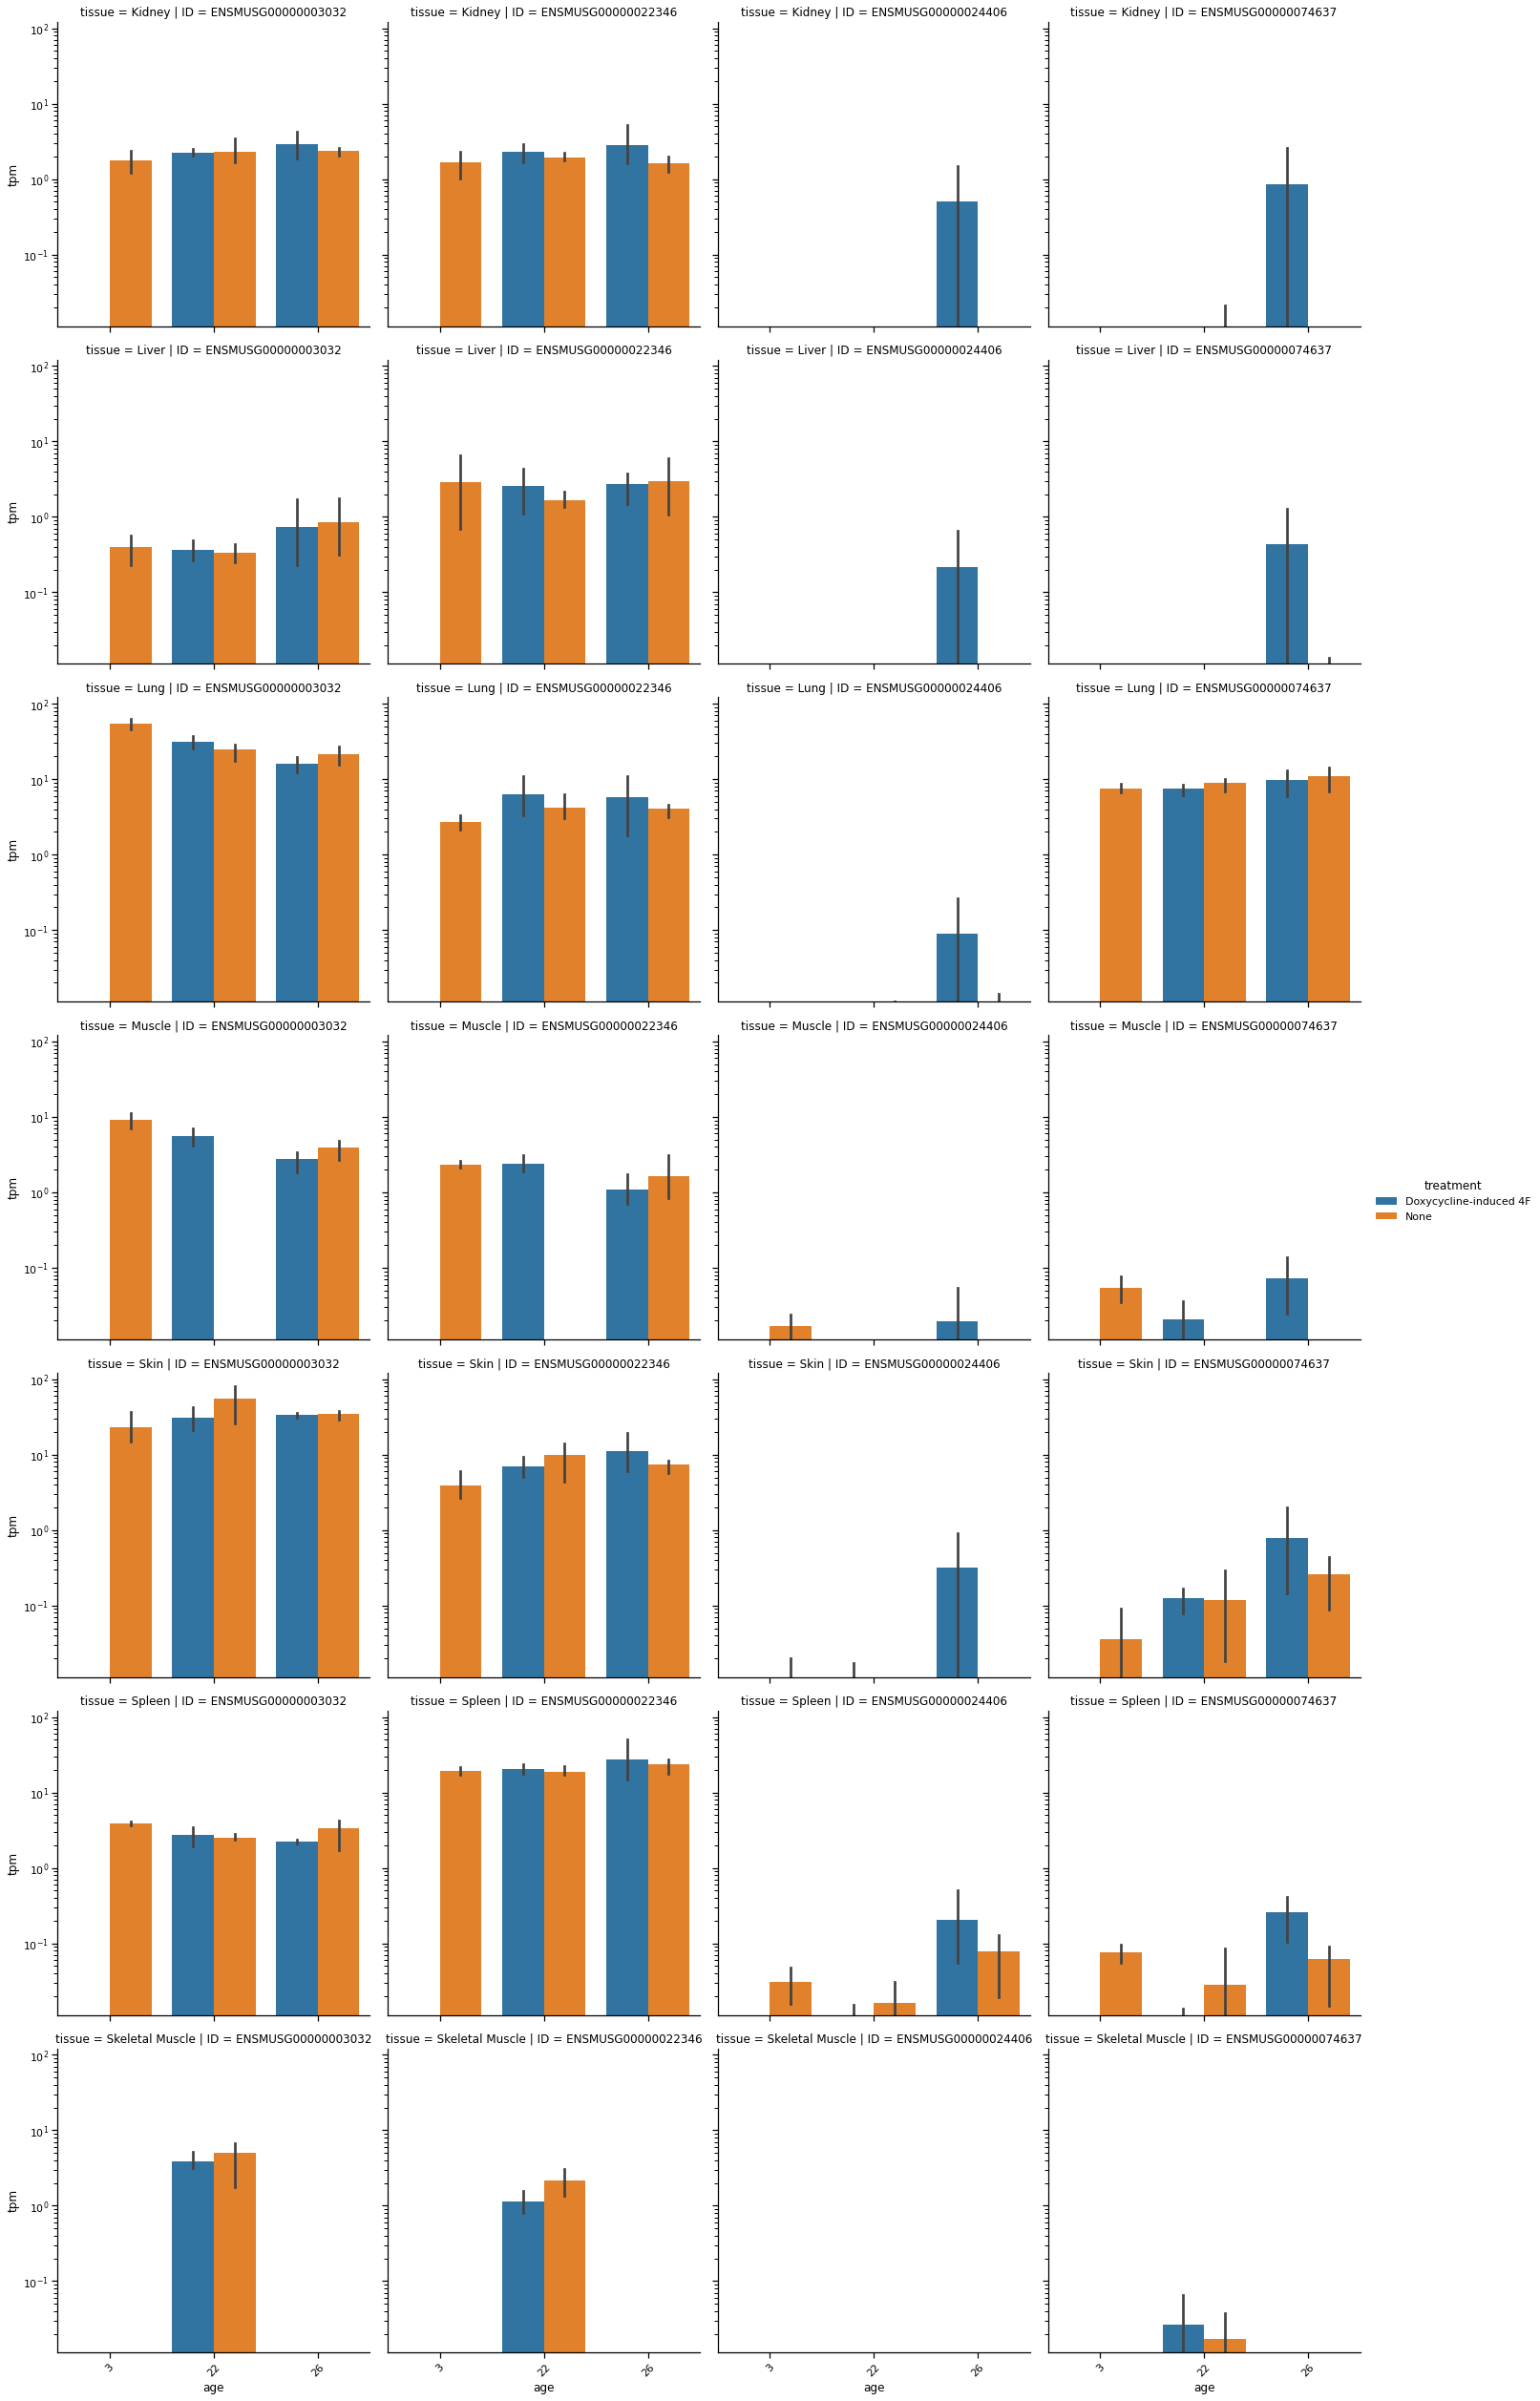

In [65]:
with sns.plotting_context('notebook'):
    g = sns.catplot(
        data=yamanaka_full, 
        kind='bar', 
        row='tissue', 
        col='ID', 
        x='age', 
        hue='treatment', 
        y='tpm',
        # sharey=False,
    )
    for axes in g.axes:
        for ax in axes:
            _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            _ = ax.set_yscale('log')

Maybe on the margins there is slight upregulation with Dox+, but I'll need real statistics (see: use an R package for differential expression) to really conclude things.

# Clustering

What experimental factor seems to drive transcriptional differences?

In [66]:
square_counts = (
    counts.merge(metadata, left_on='title', right_index=True)
        .reset_index()
        .pivot(index=['tissue', 'treatment', 'strain', 'age', 'title'], columns='ID', values='tpm')
        .replace(np.nan, 0)
)
square_counts.shape
square_counts.head()

(180, 52636)

ID                                                ENSMUSG00000000001  \
tissue treatment strain  age title                                     
Kidney Control   C57BL/6 22  Kidney_Control_6530            4.321519   
                             Kidney_Control_6531            4.067459   
                             Kidney_Control_6532            4.053097   
                             Kidney_Control_6533            3.897779   
                             Kidney_Control_6534            4.107531   

ID                                                ENSMUSG00000000003  \
tissue treatment strain  age title                                     
Kidney Control   C57BL/6 22  Kidney_Control_6530                 0.0   
                             Kidney_Control_6531                 0.0   
                             Kidney_Control_6532                 0.0   
                             Kidney_Control_6533                 0.0   
                             Kidney_Control_6534                 0.0   

ID                                                ENSMUSG00000000028  \
tissue treatment strain  age title                                     
Kidney Control   C57BL/6 22  Kidney_Control_6530            0.060375   
                             Kidney_Control_6531            0.059927   
                             Kidney_Control_6532            0.050803   
                             Kidney_Control_6533            0.042936   
                             Kidney_Control_6534            0.072056   

ID                                                ENSMUSG00000000031  \
tissue treatment strain  age title                                     
Kidney Control   C57BL/6 22  Kidney_Control_6530            0.024600   
                             Kidney_Control_6531            0.106275   
                             Kidney_Control_6532            0.122129   
                             Kidney_Control_6533            0.019475   
                             Kidney_Control_6534            0.198776   

ID                                                ENSMUSG00000000037  \
tissue treatment strain  age title                                     
Kidney Control   C57BL/6 22  Kidney_Control_6530            0.002388   
                             Kidney_Control_6531            0.001587   
                             Kidney_Control_6532            0.002837   
                             Kidney_Control_6533            0.003781   
                             Kidney_Control_6534            0.002121   

ID                                                ENSMUSG00000000049  \
tissue treatment strain  age title                                     
Kidney Control   C57BL/6 22  Kidney_Control_6530            0.172638   
                             Kidney_Control_6531            0.089411   
                             Kidney_Control_6532            0.000501   
                             Kidney_Control_6533            0.001079   
                             Kidney_Control_6534            0.001049   

ID                                                ENSMUSG00000000056  \
tissue treatment strain  age title                                     
Kidney Control   C57BL/6 22  Kidney_Control_6530            2.930324   
                             Kidney_Control_6531            4.002426   
                             Kidney_Control_6532            2.978299   
                             Kidney_Control_6533            3.803169   
                             Kidney_Control_6534            3.222352   

ID                                                ENSMUSG00000000058  \
tissue treatment strain  age title                                     
Kidney Control   C57BL/6 22  Kidney_Control_6530            6.105020   
                             Kidney_Control_6531            5.681248   
                             Kidney_Control_6532            9.124147   
                             Kidney_Control_6533            9.753150   
                             Kidn

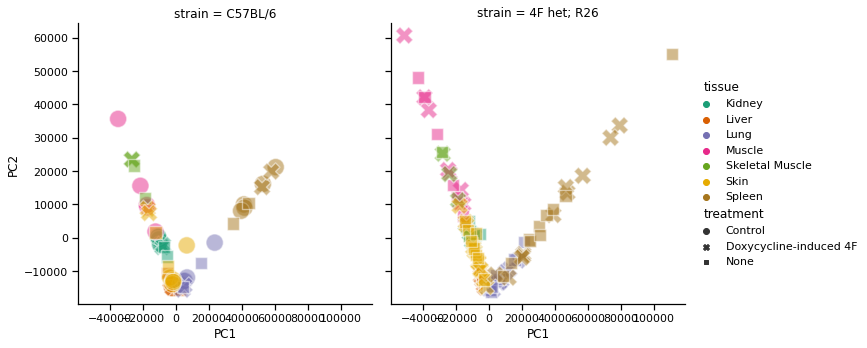

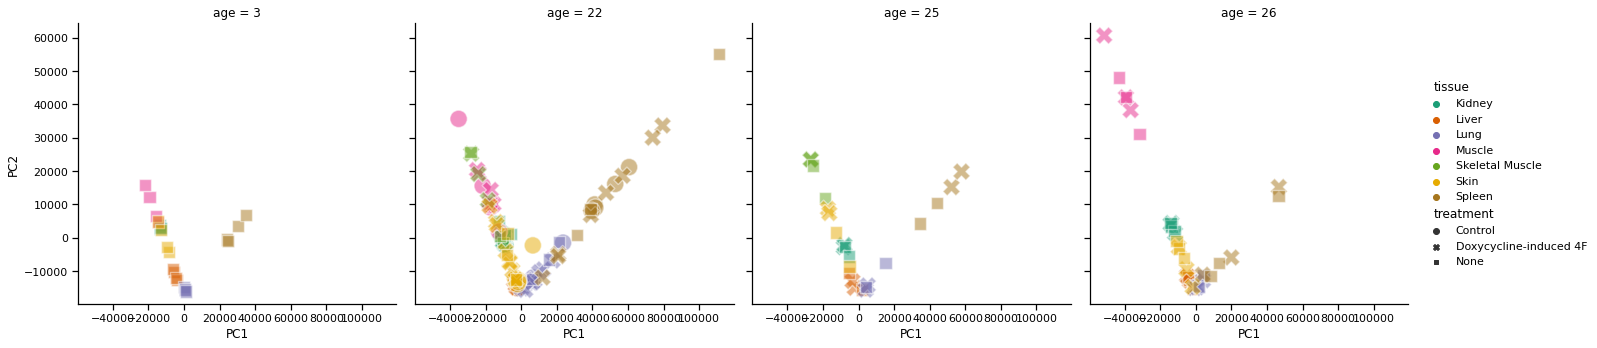

In [67]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_df = pd.DataFrame(
    pca.fit_transform(square_counts), 
    columns=['PC1', 'PC2'], 
    index=square_counts.index
)

with sns.plotting_context('notebook'):
    g = sns.relplot(
        data=pca_df.reset_index(),
        x='PC1',
        y='PC2',
        col='strain',
        # row='organ',
        # col_wraxp=2,
        style='treatment',
        hue='tissue',
        # col='strain',
        s=300,
        alpha=0.5,
        palette='Dark2'
    )
    
    g = sns.relplot(
        data=pca_df.reset_index(),
        x='PC1',
        y='PC2',
        col='age',
        style='treatment',
        hue='tissue',
        s=300,
        alpha=0.5,
        palette='Dark2',

)

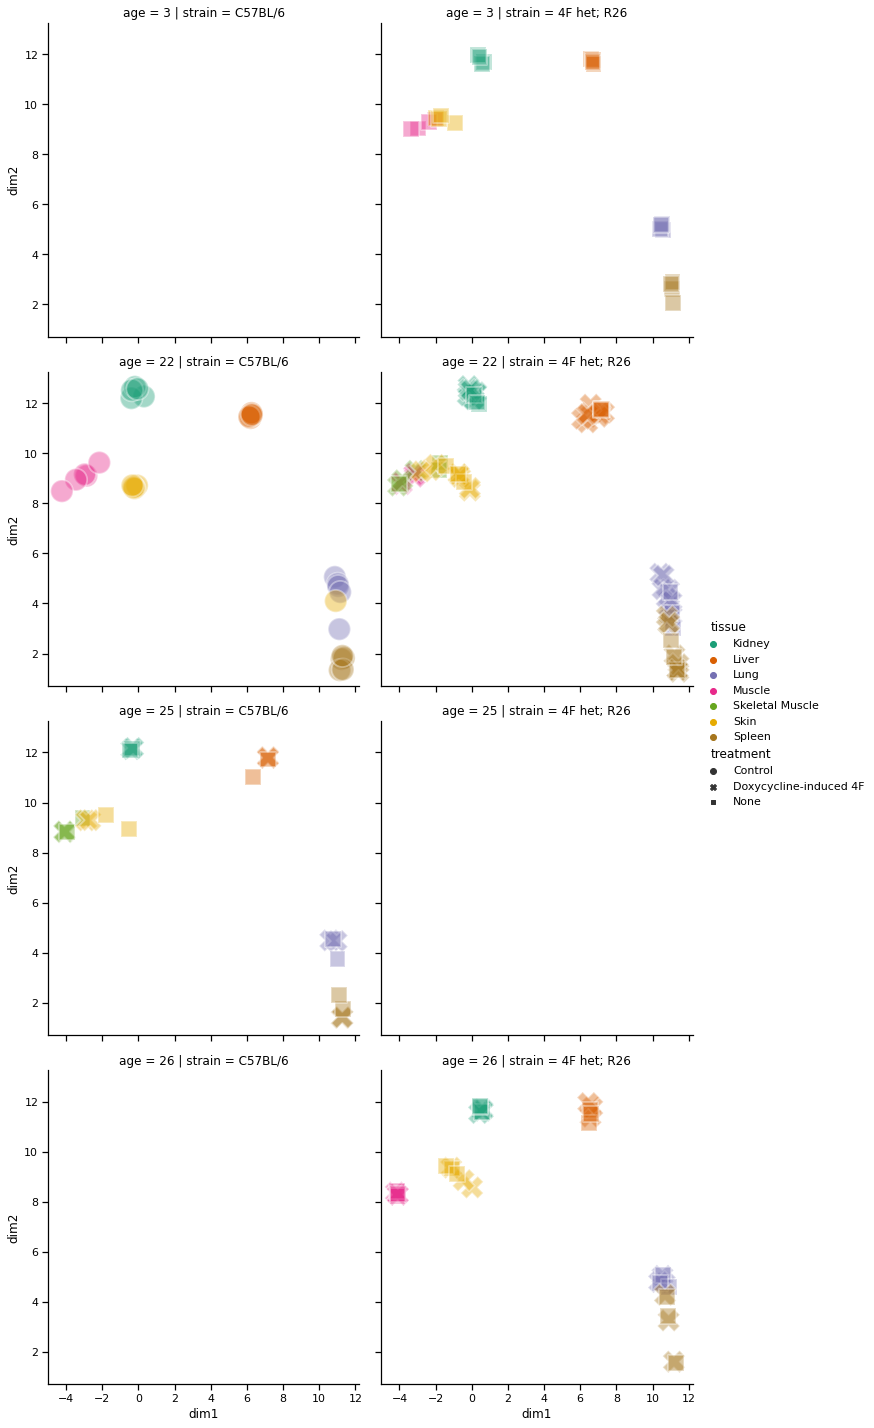

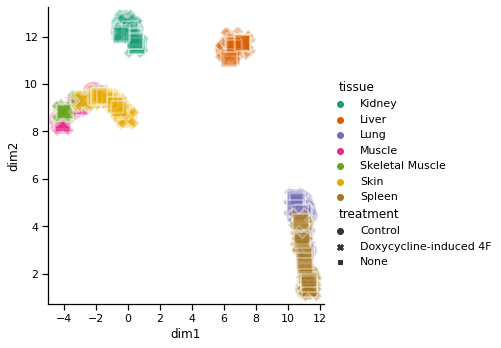

In [82]:
from umap import UMAP
clusterable_embedding = UMAP(
    n_neighbors=32,
    min_dist=0.0,
    n_components=2,
    random_state=32,
).fit_transform(square_counts)


umap_df = pd.DataFrame(
    clusterable_embedding, 
    columns=['dim1', 'dim2'], 
    index=square_counts.index
)

with sns.plotting_context('notebook'):
    g = sns.relplot(
        data=umap_df.reset_index(),
        x='dim1',
        y='dim2',
        col='strain',
        row='age',
        hue='tissue',
        style='treatment',
        s=500,
        alpha=0.4,
        palette='Dark2'
    )

    g = sns.relplot(
        data=umap_df.reset_index(),
        x='dim1',
        y='dim2',
        style='treatment',
        hue='tissue',
        s=500,
        alpha=0.4,
        palette='Dark2',

    )


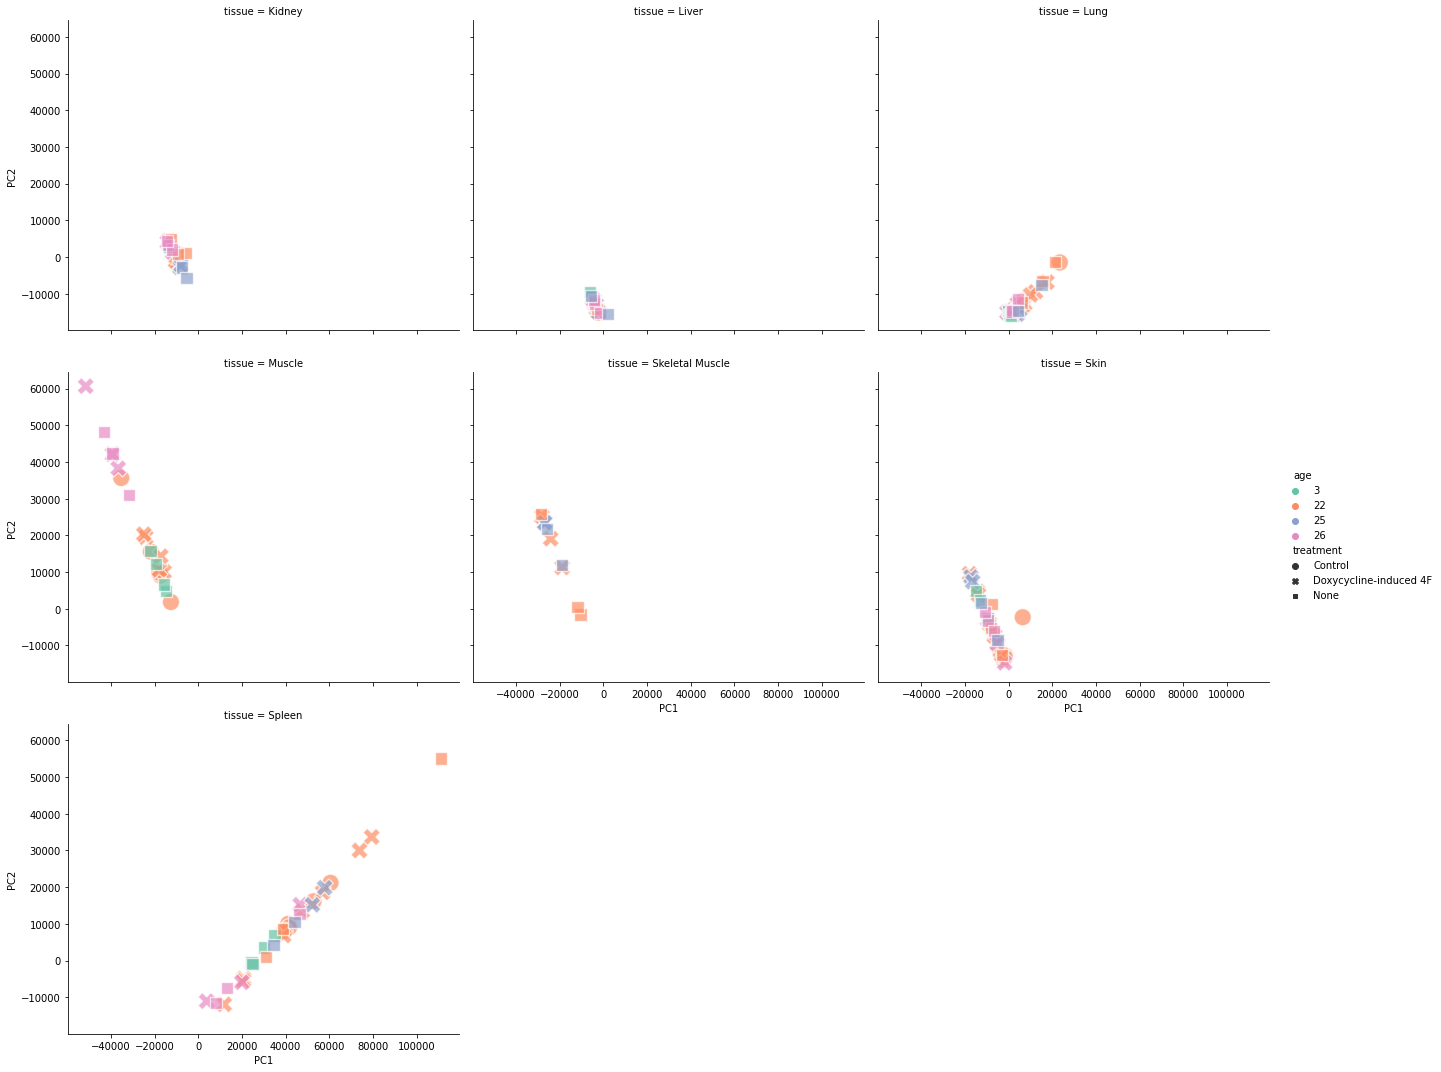

In [75]:
sns.relplot(
    data=pca_df.reset_index().dropna(subset=['age']),
    x='PC1',
    y='PC2',
    hue='age',
    style='treatment',
    col='tissue',
    col_wrap=3,
    s=300,
    palette='Set2',
    alpha=0.7,
    aspect=1.2
)


# Pre-DESeq conclusions

Unsurprisingly in retrospect, the biggest axis of variation is the tissue type.

Oct3/4 never seems to get turned on in any condition—is this an artifact? I notice in some of the extended figures it also seems turned off. Seems odd.

TPM plots only pointed us towards the obvious, doesn't shed light on the impact sex of the mice, Dox+/-, genetic background, or age has

Important note: There are a few points from the PCA (e.g., that Spleen outlier) that seem suspicious. The spleen samples overall seem to show the greatest heterogeneity, so I am unsure whether this is within expected values or not. I'll need to look in the literature to see if there are any clues.

In [94]:
metadata['group'] = metadata.index.str.extract('(\w+_.*)_')

countData = counts.pivot(index='title', columns='ID', values='numreads').T
colData = metadata.copy()

In [95]:
colData.shape
countData.shape

(180, 7)

(52636, 180)

In [96]:
countData

title,4F_Kidney_dox-treated_0990,4F_Kidney_dox-treated_0996,4F_Kidney_dox-treated_1002,4F_Kidney_non-dox_1008,4F_Kidney_non-dox_1014,4F_Kidney_non-dox_1020,4F_Liver_dox-treated_0988,4F_Liver_dox-treated_0994,4F_Liver_dox-treated_1000,4F_Liver_non-dox_1006,...,Young_Muscle_non-dox_5282,Young_Muscle_non-dox_5288,Young_Skin_non-dox_5269,Young_Skin_non-dox_5275,Young_Skin_non-dox_5281,Young_Skin_non-dox_5287,Young_Spleen_non-dox_5267,Young_Spleen_non-dox_5273,Young_Spleen_non-dox_5279,Young_Spleen_non-dox_5285
ID,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,3839,2877,4481,5292,2835,2406,3293,2819,2462,2780,...,1545,1338,1863,4844,1971,1574,5015,3839,4922,5234
ENSMUSG00000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000028,56,38,91,64,65,44,74,44,88,19,...,145,111,120,187,95,84,477,346,1054,231
ENSMUSG00000000031,6,7,8,1,3,5,64,11,32,30,...,20252,27473,16862,24536,36878,30264,33,14,10,27
ENSMUSG00000000037,6,9,15,17,6,8,0,5,1,0,...,20,6,25,63,24,18,27,13,70,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000114964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2
ENSMUSG00000114965,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,5,0,1,1
ENSMUSG00000114966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
